This is a sample script for solving the optimisation problem with constraint.
The basic reasoning is, we use gradient descent to minimise the cost function 
$$J(x) = \sum_{t} \Big[ k_1(t) \big(P_{11}(t) + P_{12}(t)\big) + k_2(t) \big(P_{21}(t) + P_{22}(t)\big) + E_1(t) U_1(t) + E_2(t) U_2(t) \Big].$$
Then, the constraints on the total power supply available, total power needed by the sinks, are formulated as regularisation terms.

 **Supply Constraints** (Soft Constraint)

$$
P_{11}(t) + P_{12}(t) \leq P_{1T}(t), \quad P_{21}(t) + P_{22}(t) \leq P_{2T}(t)
$$

We define a penalty term:

$$
\mathcal{L}_{\text{supply}} = \sum_t \lambda_s \left( \max(0, P_{11}(t) + P_{12}(t) - P_{1T}(t))^2 + \max(0, P_{21}(t) + P_{22}(t) - P_{2T}(t))^2 \right)
$$
where $ \lambda_s $ is a hyperparameter that controls how strongly we enforce this constraint.


**Demand Constraints** (Soft Constraint)

$$
P_{11}(t) L_{d11} + P_{21}(t) L_{d21} + U_1(t) = P_{D1}(t)
$$

We use a squared loss:

$$
\mathcal{L}_{\text{demand}} = \sum_t \lambda_d \left( P_{11}(t) L_{d11} + P_{21}(t) L_{d21} + U_1(t) - P_{D1}(t) \right)^2
$$

and similarly for City 2.

**Non-negativity Constraints** (Soft Constraint)

Instead of hard constraints:

$$
P_{ij}(t) \geq 0, \quad U_k(t) \geq 0
$$

we can use **ReLU activation** to ensure they remain positive:

$$
P_{ij}(t) = \max(0, P_{ij}(t)), \quad U_k(t) = \max(0, U_k(t))
$$

or include a penalty term:

$$
\mathcal{L}_{\text{neg}} = \sum_t \lambda_n \sum_{i,j} \max(0, -P_{ij}(t))^2 + \sum_k \max(0, -U_k(t))^2
$$

---

### **Total Loss Function**

The final loss function for gradient descent is:

$$
\mathcal{L}(x) = J(x) + \mathcal{L}_{\text{supply}} + \mathcal{L}_{\text{demand}} + \mathcal{L}_{\text{neg}}
$$

and the variables (time-dependent) to be optimised are P11, P12, P21 and P22


In [16]:
import torch
import matplotlib.pyplot as plt

In [20]:
# Define time steps
T = 3  # Example 3 time periods
device = torch.device("cpu")  # Use "cuda" if available

# Initialize decision variables (power allocations)
P11 = torch.rand(T, requires_grad=True, device=device)
P12 = torch.rand(T, requires_grad=True, device=device)
P21 = torch.rand(T, requires_grad=True, device=device)
P22 = torch.rand(T, requires_grad=True, device=device)

# Constants (example values)
P1T = torch.tensor([100, 120, 110], dtype=torch.float, device=device)
P2T = torch.tensor([90, 80, 100], dtype=torch.float, device=device)
PD1 = torch.tensor([80, 100, 90], dtype=torch.float, device=device)
PD2 = torch.tensor([70, 60, 100], dtype=torch.float, device=device)

L_d11, L_d12, L_d21, L_d22 = 0.95, 0.90, 0.92, 0.93  # Loss factors
k1 = torch.tensor([1.0, 1.1, 1.2], dtype=torch.float, device=device)
k2 = torch.tensor([1.3, 1.2, 1.0], dtype=torch.float, device=device)
E1 = torch.tensor([10, 10, 10], dtype=torch.float, device=device)
E2 = torch.tensor([10, 10, 10], dtype=torch.float, device=device)

# Hyperparameters for constraint penalties
λ_s = 100  # Supply penalty
λ_n = 100  # Non-negativity penalty

# Define optimizer
optimizer = torch.optim.Adam([P11, P12, P21, P22], lr=0.02)
losses = []

# Gradient Descent Loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Compute U1 and U2 explicitly (not optimizing them directly)
    U1 = PD1 - (P11 * L_d11 + P21 * L_d21)
    U2 = PD2 - (P12 * L_d12 + P22 * L_d22)

    # Cost function
    J = torch.sum(k1 * (P11 + P12) + k2 * (P21 + P22) + E1 * U1 + E2 * U2)

    # Supply constraint penalties
    L_supply = λ_s * torch.sum(
        torch.relu(P11 + P12 - P1T) ** 2 + torch.relu(P21 + P22 - P2T) ** 2
    )

    # Non-negativity penalty (to prevent negative power allocations)
    L_neg = λ_n * torch.sum(
        torch.relu(-P11) ** 2
        + torch.relu(-P12) ** 2
        + torch.relu(-P21) ** 2
        + torch.relu(-P22) ** 2
        + torch.relu(-U1) ** 2
        + torch.relu(-U2) ** 2
    )

    # Total loss
    L_total = J + L_supply + L_neg
    losses.append(L_total.item())
    # Compute gradients and update
    L_total.backward()
    optimizer.step()

    # Print every 500 iterations
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {L_total.item()}")

# Print final results
print("\nOptimized Power Dispatch:")
print(f"P11: {P11.detach().cpu().numpy()}")
print(f"P12: {P12.detach().cpu().numpy()}")
print(f"P21: {P21.detach().cpu().numpy()}")
print(f"P22: {P22.detach().cpu().numpy()}")
print(f"U1:  {U1.detach().cpu().numpy()}")  # Computed, not optimized
print(f"U2:  {U2.detach().cpu().numpy()}")  # Computed, not optimized

Epoch 0, Loss: 4968.1630859375
Epoch 500, Loss: 3994.1640625
Epoch 1000, Loss: 3020.15576171875
Epoch 1500, Loss: 2046.133544921875
Epoch 2000, Loss: 1226.1307373046875
Epoch 2500, Loss: 743.0786743164062
Epoch 3000, Loss: 609.3978271484375
Epoch 3500, Loss: 609.1563720703125
Epoch 4000, Loss: 608.8482666015625
Epoch 4500, Loss: 608.4509887695312
Epoch 5000, Loss: 607.93994140625
Epoch 5500, Loss: 607.2837524414062
Epoch 6000, Loss: 606.4426879882812
Epoch 6500, Loss: 605.3670043945312
Epoch 7000, Loss: 603.995849609375
Epoch 7500, Loss: 603.2452392578125
Epoch 8000, Loss: 602.9738159179688
Epoch 8500, Loss: 602.6295776367188
Epoch 9000, Loss: 602.1962280273438
Epoch 9500, Loss: 601.6719970703125

Optimized Power Dispatch:
P11: [55.70947  68.727806 53.028328]
P12: [44.292095 46.81246  52.37819 ]
P21: [29.477201 37.77431  43.116005]
P22: [32.451614 19.260492 56.885048]
U1:  [-0.04291534 -0.04383087 -0.04354858]
U2:  [-0.04276276 -0.04388809 -0.04338074]


Text(0.5, 1.0, 'Loss vs Epoch')

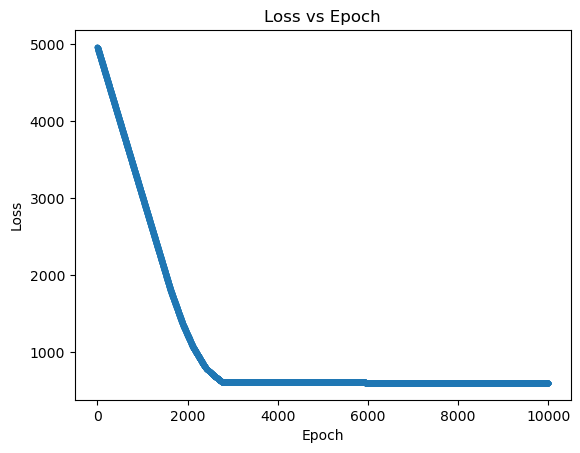

In [21]:
plt.plot(losses, ".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")